# Mod 4 Project - Building Model to Predict House Price

The purpose of this project is to use Zillow's historical house sale data to build a machine learning data model that can help to predict future house sale price in 3 years.

The data is really big, of course, we can iteratively run many times for different areas, or we can run the whole dataset on a very powerful computer.However, we will narrow down the investment locations; for the purpose of making the investment advice to be more realistic and useful, I did some research about economic, poticical, and environmental  conditions to choose an area that can be a very good candidate for investment in housing. The best candidate is North Carolina. 

From that, we can go further to understand more about Profit, ROI to choose some best areas have best potential to invest in for profits in 3 year.
  
**Profit** - describes the financial benefit realized when revenue generated from a business activity exceeds the expenses, costs, and taxes involved. Profit is calculated as total revenue less total expenses. 
  
**ROI - Return on investment**  measures the gain or loss generated on an investment relative to the amount of money invested. ROI is usually expressed as a percentage and is typically used for personal financial decisions, to compare a company's profitability or to compare the efficiency of different investments.


# Step 1: Load, Clean and Prepare the Data

In [1]:
# import all neccessary libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import itertools

# ignore all harmless waring to keep the notebook clean
warnings.filterwarnings('ignore')

# keep the plot inline in notebookb
%matplotlib inline

In [2]:
# load Zillow data
df = pd.read_csv('zillow_data.csv')

In [3]:
# quick look at the head of data
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# count the null columns
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum().head()

Metro      1043
1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
dtype: int64

In [5]:
# glance look at the null data
pd.set_option('display.max_columns', 999)
print(df[df.isnull().any(axis=1)][null_columns].head())

        Metro   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
20   New York       NaN       NaN       NaN       NaN       NaN       NaN   
36   New York       NaN       NaN       NaN       NaN       NaN       NaN   
105   Chicago       NaN       NaN       NaN       NaN       NaN       NaN   
151       NaN  137100.0  136600.0  136000.0  135600.0  135300.0  135100.0   
156  New York       NaN       NaN       NaN       NaN       NaN       NaN   

      1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04  \
20        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
36        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
105       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
151  135200.0  135600.0  136100.0  136700.0  137500.0  138300.0  139000.0   
156       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

      1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11 

In [6]:
# drop columns that we don't need them
# we focus on state, county, city and zipcode only
dropped_df = df.drop(['RegionID', 'Metro', 'SizeRank'], axis=1)

In [7]:
dropped_df.head()

,RegionName,City,State,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,787900.0,794100.0,798900.0,802300.0,8061

#### Reshape from Wide to Long Format

In [8]:
def melt_data(df):
    """
    melt data of one zip code from wide format to long format
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    #melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
def melt_df(df):
    """
    Loop through all zipcodes to melt data of each zipcode.
    Then, merge all melted data back together
    """
    
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:4]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [36]:
# call the function to really melt data
melted_df = melt_df(dropped_df)

In [37]:
melted_df.head()

,RegionName,City,State,CountyName,time,value
0,60657,Chicago,IL,Cook,1996-04-01,334200.0
1,60657,Chicago,IL,Cook,1996-05-01,335400.0
2,60657,Chicago,IL,Cook,1996-06-01,336500.0
3,60657,Chicago,IL,Cook,1996-07-01,337600.0
4,60657,Chicago,IL,Cook,1996-08-01,338500.0


In [38]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3901595 entries, 0 to 264
Data columns (total 6 columns):
RegionName    int64
City          object
State         object
CountyName    object
time          datetime64[ns]
value         float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 208.4+ MB


#### Convert to Time Series Data by setting the time column as the index

In [39]:
# make it as time series
melted_df.set_index('time', inplace=True)

In [40]:
# look at the head again
melted_df.head()

,RegionName,City,State,CountyName,value
time,,,,,
1996-04-01,60657,Chicago,IL,Cook,334200.0
1996-05-01,60657,Chicago,IL,Cook,335400.0
1996-06-01,60657,Chicago,IL,Cook,336500.0
1996-07-01,60657,Chicago,IL,Cook,337600.0
1996-08-01,60657,Chicago,IL,Cook,338500.0


In [41]:
# rename columns
melted_df.rename(columns={'RegionName': 'zipcode', 'City': 'city', 'State': 'state',
                                          'CountyName': 'countyname'}, inplace=True)
melted_df.head()

,zipcode,city,state,countyname,value
time,,,,,
1996-04-01,60657,Chicago,IL,Cook,334200.0
1996-05-01,60657,Chicago,IL,Cook,335400.0
1996-06-01,60657,Chicago,IL,Cook,336500.0
1996-07-01,60657,Chicago,IL,Cook,337600.0
1996-08-01,60657,Chicago,IL,Cook,338500.0


#### Now, it's a good time to fill missing data in value column using forward fill

In [42]:
# check any columns has na/nan value, if there is missing data
melted_df.isna().any()

zipcode       False
city          False
state         False
countyname    False
value          True
dtype: bool

In [43]:
# check how data missing
null_columns = melted_df.columns[melted_df.isnull().any()]
melted_df[null_columns].isnull().sum()

value    156891
dtype: int64

#### We see `value` column has missing data
It’s often useful to be able to fill missing data with realistic values such as the average of a time period. However, if we are working with a time series problem and we really want our data to be realistic, we wouldn't want to do a backfill of our data since that’s like looking into the future and getting information you would never have at that time period.
We are going to do forward fill our data as follow.

In [44]:
#### forward fill missing value
final_df = melted_df.ffill()

In [14]:
# check missing data again
final_df.isna().any()

zipcode       False
city          False
state         False
countyname    False
value         False
dtype: bool

#### Now we see no more missing value in any column

In [15]:
# Take a look at the final dataframe before performing EDA
final_df.head()

,zipcode,city,state,countyname,value
time,,,,,
1996-04-01,60657,Chicago,IL,Cook,334200.0
1996-05-01,60657,Chicago,IL,Cook,335400.0
1996-06-01,60657,Chicago,IL,Cook,336500.0
1996-07-01,60657,Chicago,IL,Cook,337600.0
1996-08-01,60657,Chicago,IL,Cook,338500.0


#### SAVE THE CLEAN DATA TO .CSV

In [16]:
# Saved at local, couldn't push to git hub since data is too big.
# final_df.to_csv('cleaned_zillow_data.csv')

In [10]:
# # reload the final dataframe from csv file if needed
#final_df = pd.read_csv('cleaned_zillow_data.csv', index_col='time', parse_dates=True)
#final_df.head()

,zipcode,city,state,countyname,value
time,,,,,
1996-04-01,60657,Chicago,IL,Cook,334200.0
1996-05-01,60657,Chicago,IL,Cook,335400.0
1996-06-01,60657,Chicago,IL,Cook,336500.0
1996-07-01,60657,Chicago,IL,Cook,337600.0
1996-08-01,60657,Chicago,IL,Cook,338500.0


In [11]:
final_df.tail()

,zipcode,city,state,countyname,value
time,,,,,
2017-12-01,89155,Mesquite,NV,Clark,348900.0
2018-01-01,89155,Mesquite,NV,Clark,350400.0
2018-02-01,89155,Mesquite,NV,Clark,353000.0
2018-03-01,89155,Mesquite,NV,Clark,356000.0
2018-04-01,89155,Mesquite,NV,Clark,357200.0


In [12]:
final_df_NC = final_df[final_df['state'] == 'NC']
final_df_NC.head()

,zipcode,city,state,countyname,value
time,,,,,
1996-04-01,28269,Charlotte,NC,Mecklenburg,126100.0
1996-05-01,28269,Charlotte,NC,Mecklenburg,126600.0
1996-06-01,28269,Charlotte,NC,Mecklenburg,127100.0
1996-07-01,28269,Charlotte,NC,Mecklenburg,127600.0
1996-08-01,28269,Charlotte,NC,Mecklenburg,128000.0


In [13]:
final_df_NC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113420 entries, 1996-04-01 to 2018-04-01
Data columns (total 5 columns):
zipcode       113420 non-null int64
city          113420 non-null object
state         113420 non-null object
countyname    113420 non-null object
value         113420 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 5.2+ MB


# Step 2: EDA and Visualization

#### Visualization of data at a glance, just to see the general trend of some zipcodes

In [14]:
zipcodes = final_df_NC['zipcode'].unique()
len(zipcodes)

428

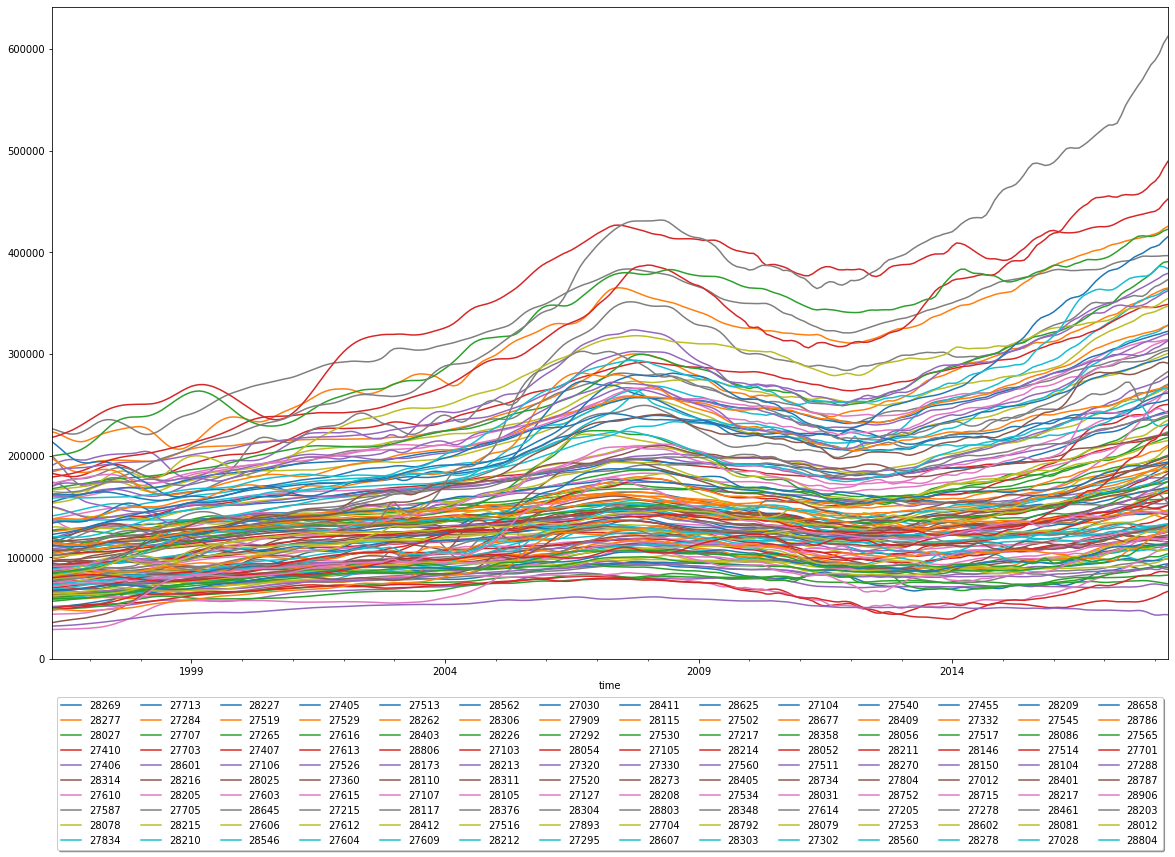

In [15]:
plt.figure(figsize=(20,12))

# slice some zipcodes at a time to test only, it takes a very very long time to draw all zipcodes
for zipcode in zipcodes[:140]:
    final_df.loc[final_df['zipcode'] == zipcode].value.plot(label=zipcode)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=14)
plt.show()

### From a quick plot above, we see that there are some zipcodes were actually growing much stronger over time than others. Some zipcodes were going down by the time

### Our jobs is to identify those high-growth zipcodes by developing data models to forecast future growth

### Now, we want to see  seasonality and trend of some zipcodes data

#### Run an ETS Decomposition

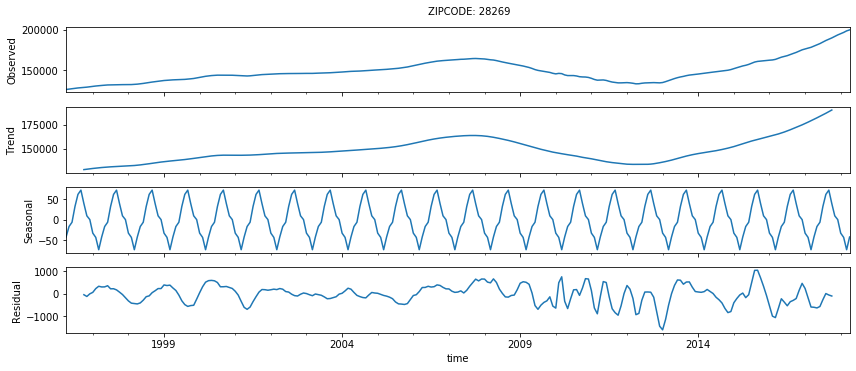

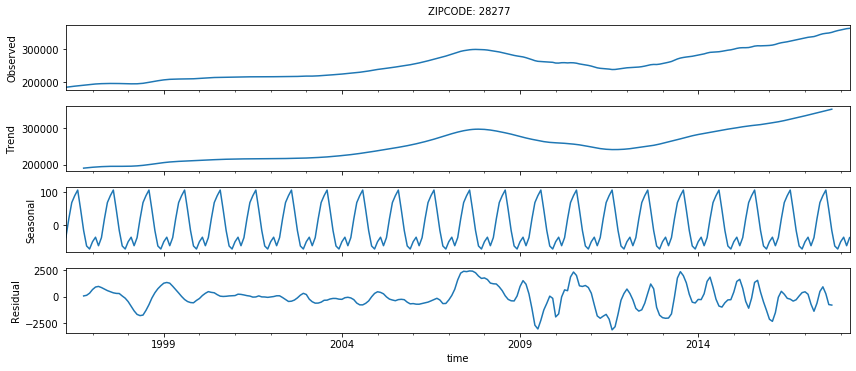

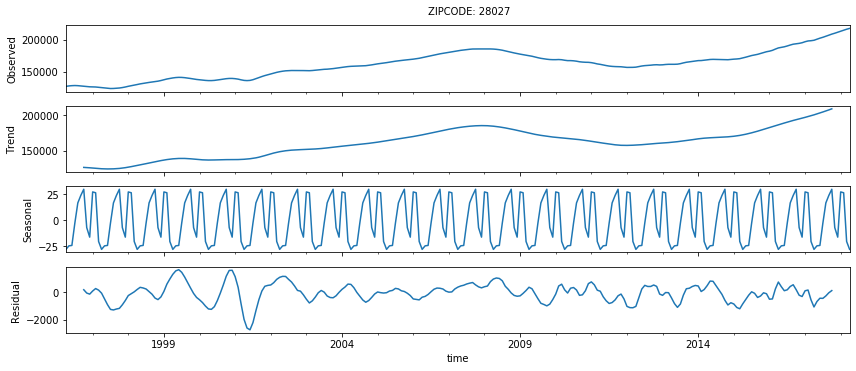

In [16]:
rcParams['figure.figsize'] = 12,5

for zipcode in zipcodes[0:3]:
    results = seasonal_decompose(final_df.loc[final_df['zipcode'] == zipcode].value, model='add')
    fig = results.plot();
    fig.text(0.5, 1, f'ZIPCODE: {zipcode}')

#### Plot ACF and PACF of some zipcodes to check corelation

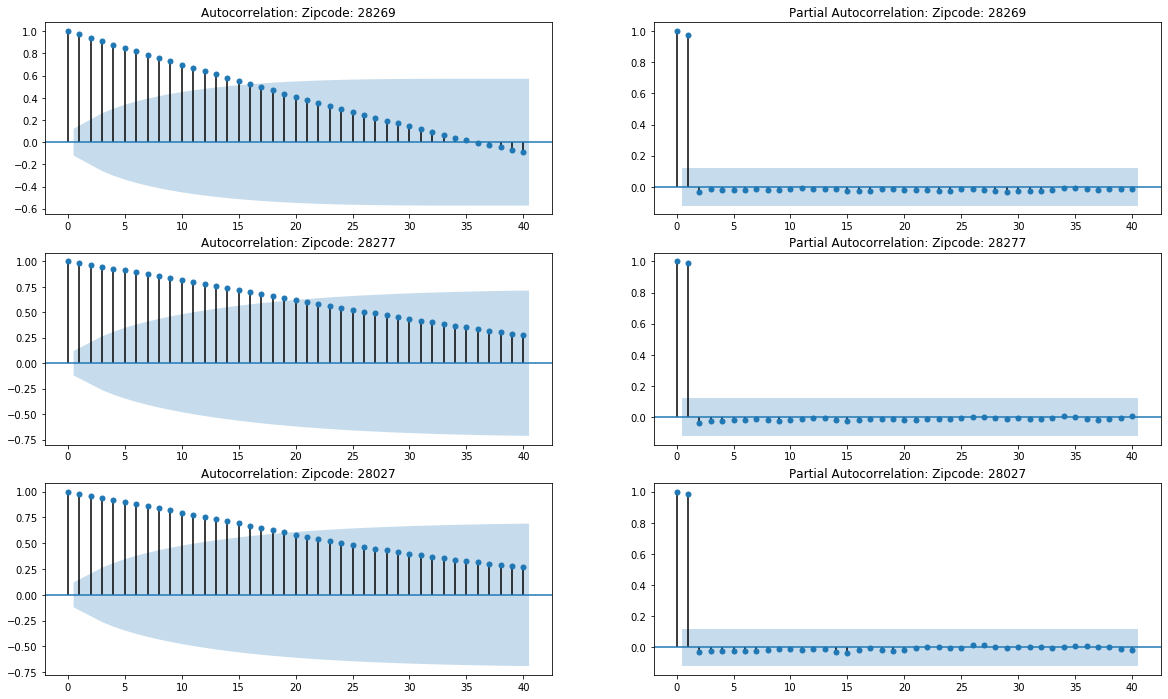

In [17]:
fig = plt.figure(figsize=(20,12))
i = 0
lags=40
for zipcode in zipcodes[0:3]:
    i += 1
    ax = plt.subplot(3,2,i)
    title = f'Autocorrelation: Zipcode: {zipcode}'
    plot_acf(final_df.loc[final_df['zipcode'] == zipcode].value, alpha=0.05, title=title, lags=lags, ax=ax);

    i += 1
    ax = plt.subplot(3,2,i)
    title=f'Partial Autocorrelation: Zipcode: {zipcode}'
    plot_pacf(final_df.loc[final_df['zipcode'] == zipcode].value, alpha=0.05, title=title, lags=lags, ax=ax);

## Automate the Augmented Dickey-Fuller Test
##### Function that performs the augmented Dickey-Fuller Test to determine if an incoming time series is stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print("==============================================================")
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print("--------------------------------------------------------------")
    print(out.to_string())
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    print("--------------------------------------------------------------")

In [19]:
# check ADF test for some zipcodes
for zipcode in zipcodes[0:3]:
    adf_test(final_df.loc[final_df['zipcode'] == zipcode].value, title= f'ZIPCODE: {zipcode}')

Augmented Dickey-Fuller Test: ZIPCODE: 28269
--------------------------------------------------------------
ADF test statistic       -1.056273
p-value                   0.732191
# lags used              13.000000
# observations          251.000000
critical value (1%)      -3.456674
critical value (5%)      -2.873125
critical value (10%)     -2.572944
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
--------------------------------------------------------------
Augmented Dickey-Fuller Test: ZIPCODE: 28277
--------------------------------------------------------------
ADF test statistic       -0.490548
p-value                   0.893848
# lags used              13.000000
# observations          251.000000
critical value (1%)      -3.456674
critical value (5%)      -2.873125
critical value (10%)     -2.572944
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-st

### Again, with the Augmented Dickey-Fuller Test results, all data for all zipcodes are seasonal.



# Step 3: Explore ARIMA Modeling to Find Best Fit Model

### Use grid search to find best fit ARIMA model of one sample zipcode

In [20]:
# One sample test zipcode
zipcode = zipcodes[0]
zipcode

28269

In [21]:
# test with one zipcode
result = auto_arima(final_df.loc[final_df['zipcode'] == zipcode].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(3, 2, 0)x(0, 1, 1, 12)   Log Likelihood               -1858.187
Date:                            Mon, 11 Nov 2019   AIC                           3728.375
Time:                                    21:18:58   BIC                           3749.527
Sample:                                         0   HQIC                          3736.887
                                            - 265                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1364     18.777      0.007      0.994     -36.666      36.939
ar.L1          0.0285      0.018      1.585      0.113      -0.007       0.064
ar.L2         -0.1190      0.010    -12.482      0.000      -0.138      -0.100
ar.L3         -0.0451      0.014     -3.285      0.001      -0.072      -0.018
ma.S.L12      -0.1220      0.008    -15.102      0.000      -0.138      -0.106
sigma2      1.224e+05   6165.976     19.858      0.000     1.1e+05    1.35e+05
===================================================================================
Ljung-Box (Q):                      189.90   Jarque-Bera (JB):               265.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### After having the best-fit model from auto_arima grid search, we double check with visualization of ETS decomposition and ACF and PACF

Text(0.5, 1, 'ZIPCODE: 28269')

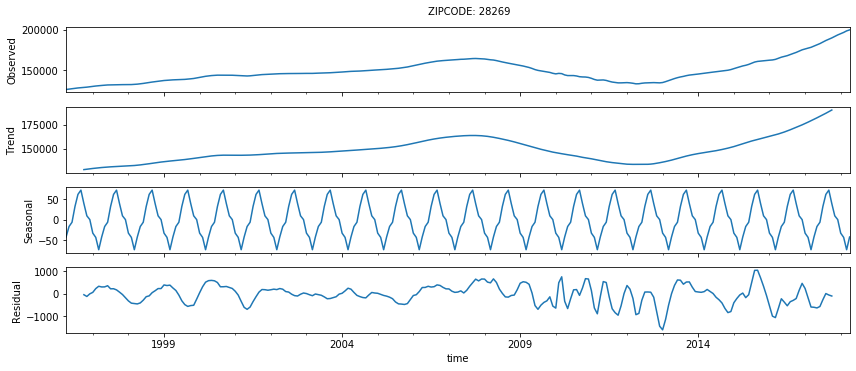

In [22]:
rcParams['figure.figsize'] = 12,5
results = seasonal_decompose(final_df.loc[final_df['zipcode'] == zipcode].value, model='add')
fig = results.plot();
fig.text(0.5,1,f'ZIPCODE: {zipcode}')

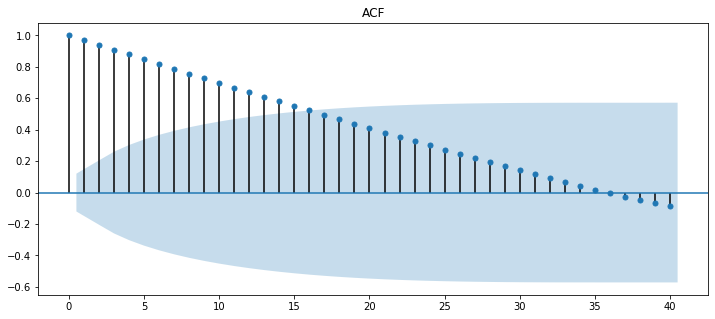

In [23]:
plot_acf(final_df.loc[final_df['zipcode'] == zipcode].value,alpha=0.05,title='ACF',lags=40);

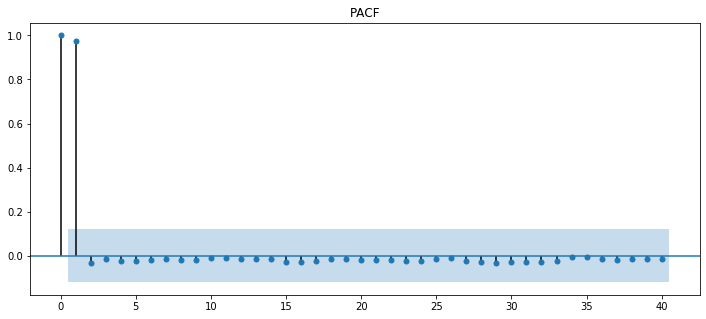

In [24]:
plot_pacf(final_df.loc[final_df['zipcode'] == zipcode].value,alpha=0.05,title='PACF',lags=40);

#### Again, the ACF & PACF plots confirm the zipcode has seasonality.

### Now, we wrote code to find best-fit models for a list of zipcodes and store the fitted models in to a DataFrame for later dispaly and use
#### For quick testing purpose we only need to test with one zipcode, but we can do for all zipcodes

In [25]:
# find the best fit model for the first test zipcode
models = []
for zipcode in zipcodes[0:1]:
    result = auto_arima(final_df.loc[final_df['zipcode'] == zipcode].value, 
                    start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                    trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
    if result._is_seasonal():
        model = {'zipcode': zipcode, 'model': 'SARIMAX', 'order': result.order,
                                     'seasonal_order': result.seasonal_order}
    else:
        model = {'zipcode': zipcode, 'model': 'ARIMA', 'order': result.order, 
                                     'seasonal_order': None}
        
    models.append(model)
    
# convert models list into DataFrame for easy reading
model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
model_df

,zipcode,model,order,seasonal_order
0,28269,SARIMAX,"(3, 2, 0)","(0, 1, 1, 12)"


#### After having the model, we split data of this zipcode into train/test dataset to evaluate the accurateness of the model

In [26]:
first_zipcode_data = final_df[final_df['zipcode']==zipcode]
first_zipcode_data.head()

,zipcode,city,state,countyname,value
time,,,,,
1996-04-01,28269,Charlotte,NC,Mecklenburg,126100.0
1996-05-01,28269,Charlotte,NC,Mecklenburg,126600.0
1996-06-01,28269,Charlotte,NC,Mecklenburg,127100.0
1996-07-01,28269,Charlotte,NC,Mecklenburg,127600.0
1996-08-01,28269,Charlotte,NC,Mecklenburg,128000.0


In [27]:
# get tail data of 3 year - test data set
first_zipcode_data.tail(36)

,zipcode,city,state,countyname,value
time,,,,,
2015-05-01,28269,Charlotte,NC,Mecklenburg,156000.0
2015-06-01,28269,Charlotte,NC,Mecklenburg,157100.0
2015-07-01,28269,Charlotte,NC,Mecklenburg,158600.0
2015-08-01,28269,Charlotte,NC,Mecklenburg,160000.0
2015-09-01,28269,Charlotte,NC,Mecklenburg,160800.0
2015-10-01,28269,Charlotte,NC,Mecklenburg,161200.0
2015-11-01,28269,Charlotte,NC,Mecklenburg,161600.0
2015-12-01,28269,Charlotte,NC,Mecklenburg,162000.0
2016-01-01,28269,Charlotte,NC,Mecklenburg,162300.0


In [28]:
# split train/test data
train_df = first_zipcode_data.loc[:'2015-04-01']
test_df = first_zipcode_data.loc['2015-05-01':]

In [29]:
train_df.tail()

,zipcode,city,state,countyname,value
time,,,,,
2014-12-01,28269,Charlotte,NC,Mecklenburg,150700.0
2015-01-01,28269,Charlotte,NC,Mecklenburg,151900.0
2015-02-01,28269,Charlotte,NC,Mecklenburg,153000.0
2015-03-01,28269,Charlotte,NC,Mecklenburg,154100.0
2015-04-01,28269,Charlotte,NC,Mecklenburg,155200.0


In [30]:
test_df

,zipcode,city,state,countyname,value
time,,,,,
2015-05-01,28269,Charlotte,NC,Mecklenburg,156000.0
2015-06-01,28269,Charlotte,NC,Mecklenburg,157100.0
2015-07-01,28269,Charlotte,NC,Mecklenburg,158600.0
2015-08-01,28269,Charlotte,NC,Mecklenburg,160000.0
2015-09-01,28269,Charlotte,NC,Mecklenburg,160800.0
2015-10-01,28269,Charlotte,NC,Mecklenburg,161200.0
2015-11-01,28269,Charlotte,NC,Mecklenburg,161600.0
2015-12-01,28269,Charlotte,NC,Mecklenburg,162000.0
2016-01-01,28269,Charlotte,NC,Mecklenburg,162300.0


In [31]:
# fit the best model with full historical data for one test zipcode
model_data = model_df.iloc[0]
arima_model = sm.tsa.statespace.SARIMAX(train_df['value'], order=model_data['order'],
                                        seasonal_order=model_data['seasonal_order'], 
                                        enforce_stationarity=False, enforce_invertibility=False)

# fit the model and print results
fitted_model = arima_model.fit()

#### Printing the diagnostics of the model

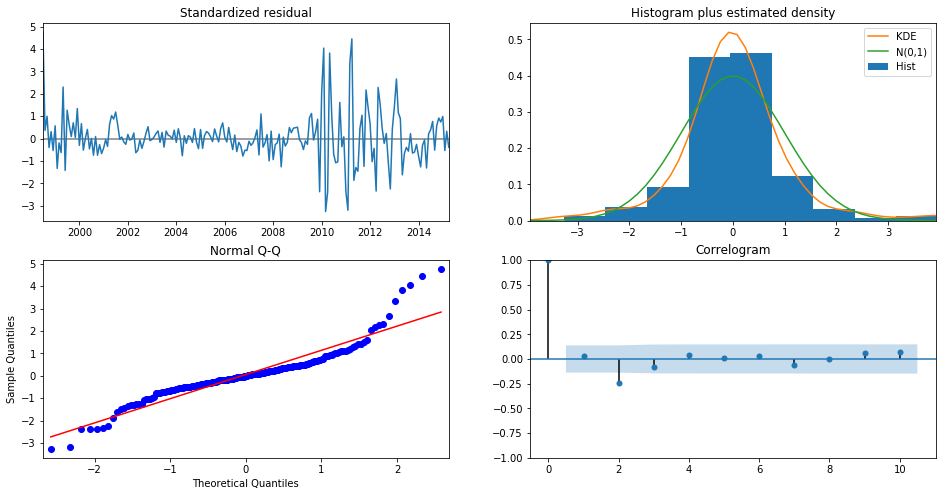

In [32]:
# plot model diagnostics
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Predict value for the next 36 months

In [33]:
# forecast into the future
start_date = pd.to_datetime('2015-05-01')
end_date = pd.to_datetime('2018-04-01')
forecast_values = fitted_model.predict(start=start_date, end=end_date, 
                                       typ='levels', dynamic=True).rename('predict')

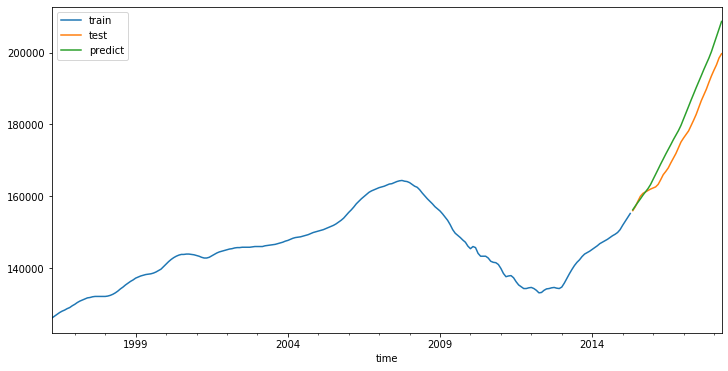

In [34]:
# plot historical and forecasted data
train_df['train'] = train_df['value']
train_df['train'].plot(legend=True,figsize=(12,6))
test_df['test'] = test_df['value']
test_df['test'].plot(legend=True)
forecast_values.plot(legend=True)


### Calculate prediction error

In [35]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test_df['value'], forecast_values)
print(f'RMSE: {error}')

RMSE: 5460.3206898880435


In [36]:
# calculate ROI, Profit
date_range = pd.date_range(start_date, periods=36, freq='MS')
forecast = pd.DataFrame(forecast_values, index=date_range[:])
value = train_df.iloc[-1]['value']
value_after_1_year = round(forecast.iloc[1*12-1]['predict'], 0)
value_after_2_year = round(forecast.iloc[2*12-1]['predict'], 0)
value_after_3_year = round(forecast.iloc[3*12-1]['predict'], 0)
forecast_data = {'Zipcode': zipcode, 'Current Value': value, 
                 'Value After 1 Year': value_after_1_year,
                 'Value After 2 Year': value_after_2_year,
                 'Value After 3 Year': value_after_3_year,
                 'Profit After 1 Year': value_after_1_year - value,
                 'Profit After 2 Year': value_after_2_year - value,
                 'Profit After 3 Year': value_after_3_year - value,
                 'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                 'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                 'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
forecast_data

{'Zipcode': 28269,
 'Current Value': 155200.0,
 'Value After 1 Year': 168977.0,
 'Value After 2 Year': 186806.0,
 'Value After 3 Year': 208684.0,
 'Profit After 1 Year': 13777.0,
 'Profit After 2 Year': 31606.0,
 'Profit After 3 Year': 53484.0,
 'ROI After 1 Year': 0.09,
 'ROI After 2 Year': 0.2,
 'ROI After 3 Year': 0.34}

# Step 5: Modelling and Forecasting The Future for All Zipcodes

#### Now we rewrite all the code for finding best models, fitting models and forecasting into reusable functions to perform forecasting for all the chosen zipcodes

In [37]:
# function to find best fit model
def find_best_fit_models(dataframe):
    """
    This function use auto_arima to find the best fit model for each zipcode
    provided in the ``zipcodes`` list.
    
    Parameters:
    ------------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    
    Return:
    ------------
    A DataFrame with following data columns: ['zipcode', 'model', 'order', 'seasonal_order']
    """
    # list to store best fit models
    models = []
    
    # zipcodes
    zipcodes = dataframe['zipcode'].unique()
    
    # loop through all zipcodes to find best model for each zipcode
    for zipcode in zipcodes:
        # call auto_arima to find best model
        result = auto_arima(dataframe.loc[dataframe['zipcode'] == zipcode].value, 
                            start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=None, D=1, 
                            trace=False, error_action='ignore',suppress_warnings=True, stepwise=True)
        
        # build a model dictionary and put into the returned list
        model = {'zipcode': zipcode, 'model': 'SARIMAX', 'order': result.order, 'seasonal_order': result.seasonal_order}
        models.append(model)

    # convert models list into DataFrame for easy reading
    model_df = pd.DataFrame(models, columns=['zipcode', 'model', 'order', 'seasonal_order'])
    
    return model_df

In [38]:
# function to fit model and forecast future data
def fit_and_forecast(dataframe, model_df):
    """
    This function fit each model in ``model_df`` with the data from ``dataframe``.
    Then, use the fitted model to forecast into the future and calculate the forecasted ROI.
    
    Parameters:
    -----------
    dataframe   : the house value time series DataFrame with columns: ['zipcode', 'value']
    model_df    : the model DataFrame output from function ``find_best_fit_models``
    
    Return:
    -----------
    A DataFrame with forecasted data,
    And a DataFrame with forecasted ROI data
    """
    
    # forecast data to be returned
    ROIs = []
    forecasts = []
    
    # loop through all model in model_df
    for index, model in model_df.iterrows():                
        # fit the best model with full historical data for one test zipcode
        data = dataframe[dataframe['zipcode']==model['zipcode']]
        arima_model = sm.tsa.statespace.SARIMAX(data['value'], order=model['order'], 
                                                seasonal_order=model['seasonal_order'], 
                                                enforce_stationarity=False, enforce_invertibility=False)

        # fit the model and print results
        fitted_model = arima_model.fit()
    
        # last historical data point
        current_data = data.tail(1)
        current_data.reset_index(inplace=True)
        time = current_data.iloc[0]['time']
        zipcode = current_data.iloc[0]['zipcode']
        value = current_data.iloc[0]['value']
        
        # build forecast date range
        date_range = pd.date_range(time, periods=37, freq='MS') # first date is present
        date_range = date_range[1:] # remove the first date
        
        # forecast values of the future
        forecast_values = fitted_model.predict(start=date_range[0],
                  end=date_range[-1], typ='levels').rename('value')
        
        # build forecast dataframe
        forecast_df = pd.DataFrame(forecast_values, index=date_range[:])
        forecast_df['zipcode'] = zipcode
        forecasts.append(forecast_df)
        
        # calculate and build forecasted ROI dataframe
        value_after_1_year = round(forecast_df.iloc[1*12-1]['value'], 0)
        value_after_2_year = round(forecast_df.iloc[2*12-1]['value'], 0)
        value_after_3_year = round(forecast_df.iloc[3*12-1]['value'], 0)
        roi_data = {'Zipcode': zipcode, 
                         'Current Value': value, 
                         'Value After 1 Year':  value_after_1_year,
                         'Value After 2 Year':  value_after_2_year,
                         'Value After 3 Year':  value_after_3_year,
                         'Profit After 1 Year': value_after_1_year - value,
                         'Profit After 2 Year': value_after_2_year - value,
                         'Profit After 3 Year': value_after_3_year - value,
                         'ROI After 1 Year': round((value_after_1_year - value) / value, 2),
                         'ROI After 2 Year': round((value_after_2_year - value) / value, 2),
                         'ROI After 3 Year': round((value_after_3_year - value) / value, 2)}
        
        ROIs.append(roi_data)
    
    # convert models list into DataFrame for easy reading
    roi_df = pd.DataFrame(ROIs, columns=['Zipcode', 'Current Value', 
                           'Value After 1 Year', 'Value After 2 Year', 'Value After 3 Year',
                                'Profit After 1 Year', 'Profit After 2 Year', 'Profit After 3 Year',
                                'ROI After 1 Year', 'ROI After 2 Year', 'ROI After 3 Year'])
    
    # merge all forecasts into one DataFrame
    forecast_df = pd.concat(forecasts)
    
    return forecast_df, roi_df
    

### Now we want to forecast and calculate forecasted future ROI
#### However, to run for the whole dataset with a normal computer it may takes days to finish, so we will run for one State at a time
#### In this test, we assume we want to run forecast for the state California `CA` only.

#### There are 2 options, which depends on our target customer, we might have a look  on profit. There might be some situations that the The Profit will be very big amount while ROI will not be really big since the value of the house is significantly great amount. For target customers who just want to invest in big investment, they don't want to seperate their capital into small investments. 

In [39]:
# Now, forecast the real data of Santa Clara - CA
dataframe = final_df[final_df['zipcode'].isin(zipcodes[:])]

In [44]:
# find best models - take lots of time
model_df = find_best_fit_models(dataframe)

In [71]:
model_df.head()

,zipcode,model,order,seasonal_order
0,95123,SARIMAX,"(1, 0, 0)","(0, 1, 1, 12)"
1,95051,SARIMAX,"(1, 1, 1)","(2, 1, 0, 12)"
2,95035,SARIMAX,"(1, 1, 2)","(0, 1, 1, 12)"
3,95014,SARIMAX,"(1, 1, 1)","(0, 1, 2, 12)"
4,95112,SARIMAX,"(1, 0, 1)","(2, 1, 0, 12)"


In [46]:
## save the best models for later reference
# model_df.to_csv('fitted_models_NC.csv')

In [40]:
## reload the fitted_models dataframe from csv file if needed

# read from saved models csv
model_df = pd.read_csv('fitted_models_NC.csv')

# cleanup and convert string to tuples
from ast import literal_eval
model_df = model_df.drop(['Unnamed: 0'],axis=1) 
model_df['order'] = model_df['order'].apply(lambda x : literal_eval(x))
model_df['seasonal_order'] = model_df['seasonal_order'].apply(lambda x : literal_eval(x))

#look at head
model_df.head()

,zipcode,model,order,seasonal_order
0,28269,SARIMAX,"(3, 2, 0)","(0, 1, 1, 12)"
1,28277,SARIMAX,"(1, 0, 1)","(0, 1, 1, 12)"
2,28027,SARIMAX,"(1, 0, 0)","(0, 1, 0, 12)"
3,27410,SARIMAX,"(1, 1, 1)","(0, 1, 1, 12)"
4,27406,SARIMAX,"(1, 1, 0)","(1, 1, 0, 12)"


In [50]:
# fit and forecast
forecast_df, roi_df = fit_and_forecast(dataframe, model_df)

# show result
roi_df.head()

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,Profit After 1 Year,Profit After 2 Year,Profit After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
0,28269,199700.0,215828.0,231556.0,246753.0,16128.0,31856.0,47053.0,0.08,0.16,0.24
1,28277,364800.0,388784.0,412195.0,435086.0,23984.0,47395.0,70286.0,0.07,0.13,0.19
2,28027,218000.0,237864.0,258964.0,281377.0,19864.0,40964.0,63377.0,0.09,0.19,0.29
3,27410,221500.0,226181.0,231831.0,237561.0,4681.0,10331.0,16061.0,0.02,0.05,0.07
4,27406,111300.0,118806.0,124974.0,131847.0,7506.0,13674.0,20547.0,0.07,0.12,0.18


In [42]:
# save forecast dataframe and ROI dataframe for later use
#forecast_df.to_csv('forecast_result.csv')
#roi_df.to_csv('roi_result.csv')

# Step 6: Interpreting Results & Making Conclusions

#### Sort the ROI values to get the Top 5 performers

In [51]:
# sort to get top 5 performers order by After 3rd Year
ROI_top_5_after_3_year = roi_df.sort_values(['ROI After 3 Year', 'ROI After 2 Year', 'ROI After 1 Year'],
                     ascending=False).head(5)
ROI_top_5_after_3_year

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,Profit After 1 Year,Profit After 2 Year,Profit After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
76,28208,113400.0,147530.0,189549.0,239096.0,34130.0,76149.0,125696.0,0.30,0.67,1.11
16,28205,265900.0,318158.0,377626.0,443845.0,52258.0,111726.0,177945.0,0.20,0.42,0.67
347,28756,168600.0,204380.0,236913.0,270483.0,35780.0,68313.0,101883.0,0.21,0.41,0.60
18,28215,169900.0,195954.0,226347.0,260961.0,26054.0,56447.0,91061.0,0.15,0.33,0.54
183,27896,170500.0,198796.0,227998.0,257263.0,28296.0,57498.0,86763.0,0.17,0.34,0.51


#### Sort the Profit values to get the Top 5 performers

In [52]:
# sort to get top 5 performers order by After 3rd Year
Profit_top_5_after_3_year = roi_df.sort_values(['Profit After 3 Year', 'Profit After 2 Year', 'Profit After 1 Year'],
                     ascending=False).head(5)
Profit_top_5_after_3_year

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,Profit After 1 Year,Profit After 2 Year,Profit After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
275,28207,1238000.0,1323371.0,1408624.0,1493875.0,85371.0,170624.0,255875.0,0.07,0.14,0.21
137,28203,612100.0,682103.0,763894.0,856361.0,70003.0,151794.0,244261.0,0.11,0.25,0.40
253,28204,583400.0,650755.0,719306.0,789084.0,67355.0,135906.0,205684.0,0.12,0.23,0.35
16,28205,265900.0,318158.0,377626.0,443845.0,52258.0,111726.0,177945.0,0.20,0.42,0.67
406,27562,372400.0,431658.0,490411.0,549120.0,59258.0,118011.0,176720.0,0.16,0.32,0.47


### So the Top 5 Zipcodes that would forecastedly produce most return would be in the zipcodes list above


#### Plot the historical and forecasted values of Top 5 Performers


In [53]:
# top 5 zipcodes
Profit_top_5_zipcodes = Profit_top_5_after_3_year['Zipcode'].unique()
print(f'Top 5 Zipcodes with max return in 3 years are: {Profit_top_5_zipcodes}')


Top 5 Zipcodes with max return in 3 years are: [28207 28203 28204 28205 27562]


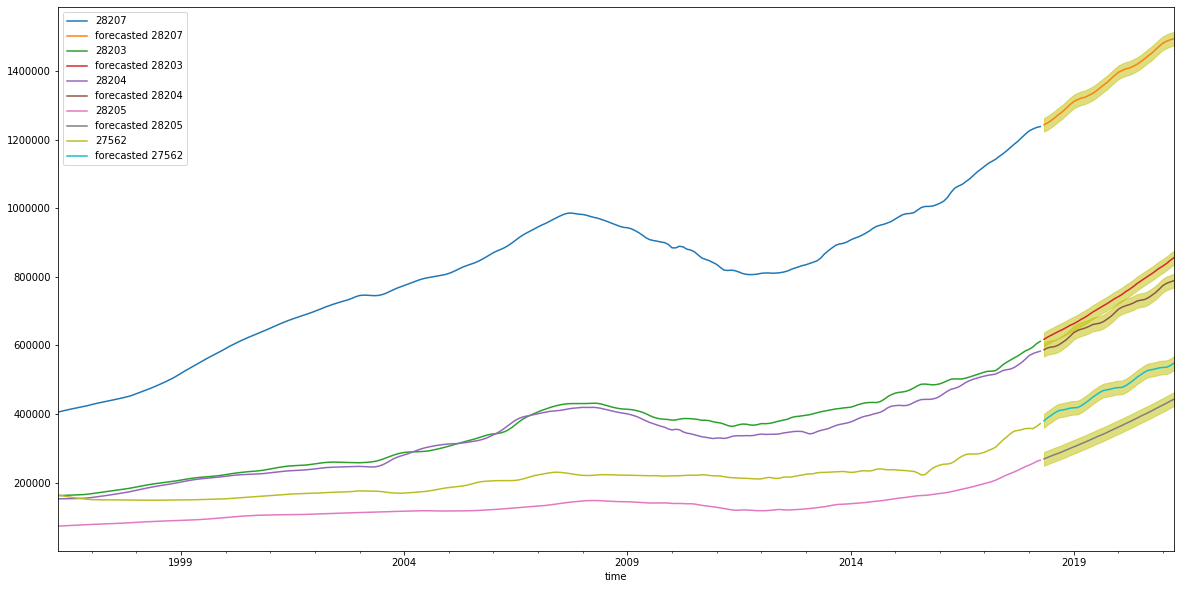

In [54]:
# plot historical value and forecasted value of Top 5 Performers
for zipcode in Profit_top_5_zipcodes:
    data = final_df[final_df['zipcode']==zipcode]
    col_name = str(zipcode)
    data[col_name] = data['value']
    ax = data[col_name].plot(legend=True, figsize=(20,10))
    
    forecast = forecast_df[forecast_df['zipcode']==zipcode]
    col_name = 'forecasted ' + str(zipcode)
    forecast[col_name] = forecast['value']
    forecast[col_name].plot(legend=True)
    
    ax.fill_between(x=forecast.index, y1=forecast[col_name] - 20000, 
                y2=forecast[col_name] + 20000, color='y', alpha=0.5)

In [55]:
Profit_top_30_after_3_year = roi_df.sort_values(['Profit After 3 Year', 'Profit After 2 Year', 'Profit After 1 Year'],
                     ascending=False).head(30)
Profit_top_30_after_3_year.head()

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,Profit After 1 Year,Profit After 2 Year,Profit After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
275,28207,1238000.0,1323371.0,1408624.0,1493875.0,85371.0,170624.0,255875.0,0.07,0.14,0.21
137,28203,612100.0,682103.0,763894.0,856361.0,70003.0,151794.0,244261.0,0.11,0.25,0.40
253,28204,583400.0,650755.0,719306.0,789084.0,67355.0,135906.0,205684.0,0.12,0.23,0.35
16,28205,265900.0,318158.0,377626.0,443845.0,52258.0,111726.0,177945.0,0.20,0.42,0.67
406,27562,372400.0,431658.0,490411.0,549120.0,59258.0,118011.0,176720.0,0.16,0.32,0.47


In [56]:
plot_Profit30_df = Profit_top_30_after_3_year.melt(id_vars='Zipcode', value_vars=['Current Value', 'Value After 3 Year'],
                              value_name='Value', var_name='Value_Type')
plot_Profit30_df['Zipcode'] = plot_Profit30_df['Zipcode'].astype('str')
plot_Profit30_df.head()

,Zipcode,Value_Type,Value
0,28207,Current Value,1238000.0
1,28203,Current Value,612100.0
2,28204,Current Value,583400.0
3,28205,Current Value,265900.0
4,27562,Current Value,372400.0


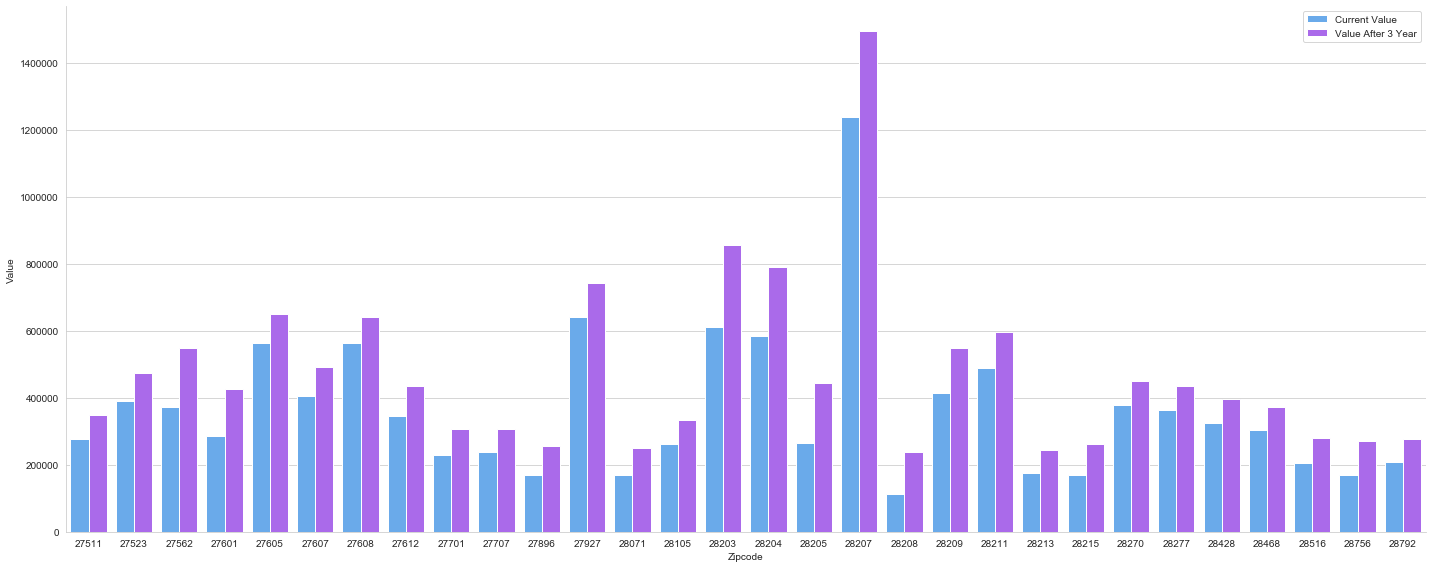

In [57]:
sns.set_style('whitegrid')
g = sns.catplot(x='Zipcode', y='Value', data=plot_Profit30_df, hue='Value_Type',
                kind='bar', palette='cool', height=8, aspect=2.5, legend = False)
plt.legend(loc='upper right');

In [58]:
Profit_top_5_after_3_year = roi_df.sort_values(['Profit After 3 Year', 'Profit After 2 Year', 'Profit After 1 Year'],
                     ascending=False).head(5)
Profit_top_5_after_3_year.head()

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,Profit After 1 Year,Profit After 2 Year,Profit After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
275,28207,1238000.0,1323371.0,1408624.0,1493875.0,85371.0,170624.0,255875.0,0.07,0.14,0.21
137,28203,612100.0,682103.0,763894.0,856361.0,70003.0,151794.0,244261.0,0.11,0.25,0.40
253,28204,583400.0,650755.0,719306.0,789084.0,67355.0,135906.0,205684.0,0.12,0.23,0.35
16,28205,265900.0,318158.0,377626.0,443845.0,52258.0,111726.0,177945.0,0.20,0.42,0.67
406,27562,372400.0,431658.0,490411.0,549120.0,59258.0,118011.0,176720.0,0.16,0.32,0.47


In [59]:
plot_Profit5_df = Profit_top_5_after_3_year.melt(id_vars='Zipcode', value_vars=['Current Value', 'Value After 3 Year'],
                              value_name='Value', var_name='Value_Type')
plot_Profit5_df['Zipcode'] = plot_Profit5_df['Zipcode'].astype('str')
plot_Profit5_df.head()

,Zipcode,Value_Type,Value
0,28207,Current Value,1238000.0
1,28203,Current Value,612100.0
2,28204,Current Value,583400.0
3,28205,Current Value,265900.0
4,27562,Current Value,372400.0


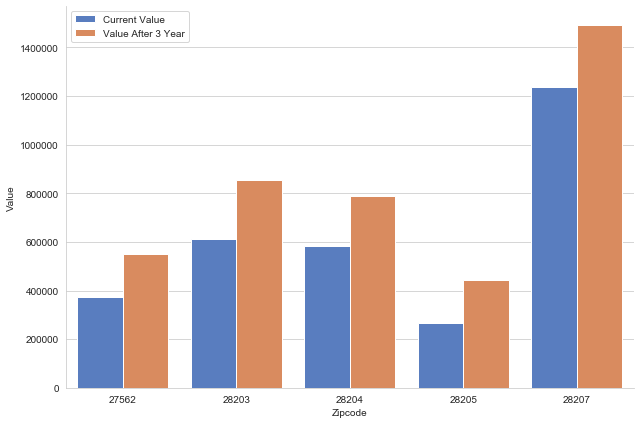

In [60]:
sns.set_style('whitegrid')
g = sns.catplot(x='Zipcode', y='Value', data=plot_Profit5_df, hue='Value_Type',
                kind='bar', palette='muted', height=6, aspect=1.5, legend = False)
plt.legend(loc='upper left');

In [61]:
# ROI top 5 zipcodes
ROI_top_5_zipcodes = ROI_top_5_after_3_year['Zipcode'].unique()
print(f'Top 5 Zipcodes with max return in 3 years are: {ROI_top_5_zipcodes}')

Top 5 Zipcodes with max return in 3 years are: [28208 28205 28756 28215 27896]


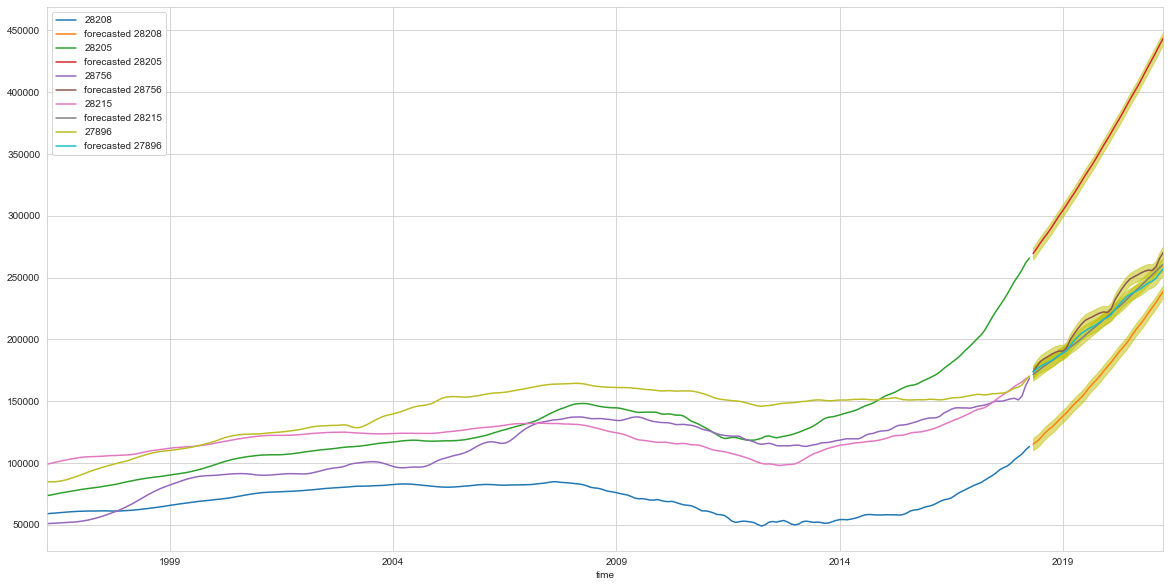

In [62]:
# plot historical value and forecasted value of ROI Top 5 Performers
for zipcode in ROI_top_5_zipcodes:
    data = final_df[final_df['zipcode']==zipcode]
    col_name = str(zipcode)
    data[col_name] = data['value']
    ax = data[col_name].plot(legend=True, figsize=(20,10))
    
    forecast = forecast_df[forecast_df['zipcode']==zipcode]
    col_name = 'forecasted ' + str(zipcode)
    forecast[col_name] = forecast['value']
    forecast[col_name].plot(legend=True)
    
    ax.fill_between(x=forecast.index, y1=forecast[col_name] - 5000, 
                y2=forecast[col_name] + 5000, color='y', alpha=0.5);

In [63]:
roi_df.head()

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,Profit After 1 Year,Profit After 2 Year,Profit After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
0,28269,199700.0,215828.0,231556.0,246753.0,16128.0,31856.0,47053.0,0.08,0.16,0.24
1,28277,364800.0,388784.0,412195.0,435086.0,23984.0,47395.0,70286.0,0.07,0.13,0.19
2,28027,218000.0,237864.0,258964.0,281377.0,19864.0,40964.0,63377.0,0.09,0.19,0.29
3,27410,221500.0,226181.0,231831.0,237561.0,4681.0,10331.0,16061.0,0.02,0.05,0.07
4,27406,111300.0,118806.0,124974.0,131847.0,7506.0,13674.0,20547.0,0.07,0.12,0.18


In [64]:
ROI_top_30_after_3_year = roi_df.sort_values(['ROI After 3 Year', 'ROI After 2 Year', 'ROI After 1 Year'],
                     ascending=False).head(30)
ROI_top_30_after_3_year.head()

,Zipcode,Current Value,Value After 1 Year,Value After 2 Year,Value After 3 Year,Profit After 1 Year,Profit After 2 Year,Profit After 3 Year,ROI After 1 Year,ROI After 2 Year,ROI After 3 Year
76,28208,113400.0,147530.0,189549.0,239096.0,34130.0,76149.0,125696.0,0.30,0.67,1.11
16,28205,265900.0,318158.0,377626.0,443845.0,52258.0,111726.0,177945.0,0.20,0.42,0.67
347,28756,168600.0,204380.0,236913.0,270483.0,35780.0,68313.0,101883.0,0.21,0.41,0.60
18,28215,169900.0,195954.0,226347.0,260961.0,26054.0,56447.0,91061.0,0.15,0.33,0.54
183,27896,170500.0,198796.0,227998.0,257263.0,28296.0,57498.0,86763.0,0.17,0.34,0.51


In [65]:
plot_ROI30_df = ROI_top_30_after_3_year.melt(id_vars='Zipcode', value_vars=['Current Value', 'Value After 3 Year'],
                              value_name='Value', var_name='Value_Type')
plot_ROI30_df['Zipcode'] = plot_ROI30_df['Zipcode'].astype('str')
plot_ROI30_df.head()

,Zipcode,Value_Type,Value
0,28208,Current Value,113400.0
1,28205,Current Value,265900.0
2,28756,Current Value,168600.0
3,28215,Current Value,169900.0
4,27896,Current Value,170500.0


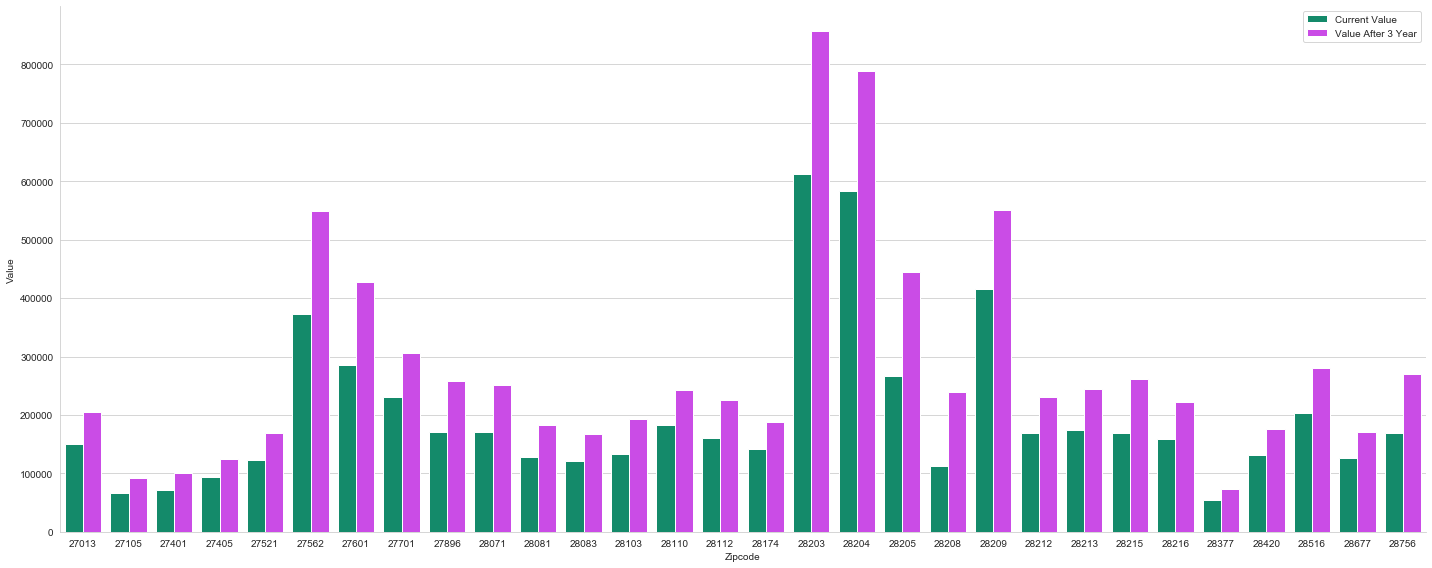

In [66]:
sns.set_style('whitegrid')
g = sns.catplot(x='Zipcode', y='Value', data=plot_ROI30_df, hue='Value_Type',
                kind='bar', palette=['#009E73', '#DA33FF'], height=8, aspect=2.5, legend=False)
plt.legend(loc='upper right');

In [67]:
plot_ROI5_df = ROI_top_5_after_3_year.melt(id_vars='Zipcode', value_vars=['Current Value', 'Value After 3 Year'],
                              value_name='Value', var_name='Value_Type')
plot_ROI5_df['Zipcode'] = plot_ROI5_df['Zipcode'].astype('str')
plot_ROI5_df

,Zipcode,Value_Type,Value
0,28208,Current Value,113400.0
1,28205,Current Value,265900.0
2,28756,Current Value,168600.0
3,28215,Current Value,169900.0
4,27896,Current Value,170500.0
5,28208,Value After 3 Year,239096.0
6,28205,Value After 3 Year,443845.0
7,28756,Value After 3 Year,270483.0
8,28215,Value After 3 Year,260961.0
9,27896,Value After 3 Year,257263.0


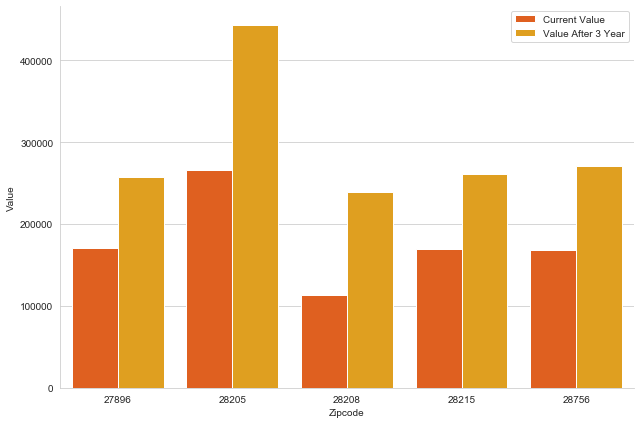

In [68]:
g = sns.catplot(x='Zipcode', y='Value', data=plot_ROI5_df, hue='Value_Type',
                kind='bar', palette='autumn', height=6, aspect=1.5, legend=False);
plt.legend(loc='upper right');

### RMSE FOR 5 ZIPCODES


In [69]:
# function to split train/test data, fit, predict and calcualte error for each zipcode
def split_fit_predict_error(dataframe, zipcode):
    # filter data for the zipcode
    zipcode_data = final_df[final_df['zipcode']==zipcode]
    
    # calculate train/test dates for 36 months
    end_train_date = zipcode_data.index.array[-37:-36][0] 
    start_test_date = zipcode_data.index.array[-36:-35][0]
    end_test_date = zipcode_data.index.array[-1:][0]
    
    # split train/test data
    train_df = first_zipcode_data.loc[:end_train_date]
    test_df = first_zipcode_data.loc[start_test_date:]
    
    # get the model for this zipcode from model dataframe
    model_data = model_df[model_df['zipcode']==zipcode]
    
    # fit the best model with full historical data for one test zipcode
    arima_model = sm.tsa.statespace.SARIMAX(train_df['value'], order=model_data.iloc[0]['order'],
                                            seasonal_order=model_data.iloc[0]['seasonal_order'], 
                                            enforce_stationarity=False, enforce_invertibility=False)

    # fit the model and print results
    fitted_model = arima_model.fit()
    
    # forecast into the future
    forecast_values = fitted_model.predict(start=start_test_date, end=end_test_date, 
                                       typ='levels', dynamic=True).rename('predict')
    # calculate error
    error = rmse(test_df['value'], forecast_values)
    
    return error

In [70]:
# calculate error for the top 5
for zipcode in ROI_top_5_zipcodes:
    error = split_fit_predict_error(final_df, zipcode)
    print(f'Zipcode: {zipcode} - Predictive Error: {round(error, 0)}')

Zipcode: 28208 - Predictive Error: 5618.0
Zipcode: 28205 - Predictive Error: 4867.0
Zipcode: 28756 - Predictive Error: 8629.0
Zipcode: 28215 - Predictive Error: 4867.0
Zipcode: 27896 - Predictive Error: 8170.0


In [71]:
# calculate error for the top 5
for zipcode in Profit_top_5_zipcodes:
    error = split_fit_predict_error(final_df, zipcode)
    print(f'Zipcode: {zipcode} - Predictive Error: {round(error, 0)}')

Zipcode: 28207 - Predictive Error: 8170.0
Zipcode: 28203 - Predictive Error: 9379.0
Zipcode: 28204 - Predictive Error: 10403.0
Zipcode: 28205 - Predictive Error: 4867.0
Zipcode: 27562 - Predictive Error: 10450.0


In [72]:
report_top5_profit = Profit_top_5_after_3_year[['Zipcode', 'Current Value', 'Profit After 3 Year', 'ROI After 3 Year']]
report_top5_profit['City'] = report_top5_profit['Zipcode'].apply(lambda zipcode : 
                                 final_df[final_df['zipcode']==zipcode].iat[0,1])
report_top5_profit = report_top5_profit[['Zipcode', 'City', 'Current Value', 'Profit After 3 Year', 'ROI After 3 Year']]
report_top5_profit

,Zipcode,City,Current Value,Profit After 3 Year,ROI After 3 Year
275,28207,Charlotte,1238000.0,255875.0,0.21
137,28203,Charlotte,612100.0,244261.0,0.40
253,28204,Charlotte,583400.0,205684.0,0.35
16,28205,Charlotte,265900.0,177945.0,0.67
406,27562,New Hill,372400.0,176720.0,0.47


In [73]:
report_top5_ROI = ROI_top_5_after_3_year[['Zipcode', 'Current Value', 'Profit After 3 Year', 'ROI After 3 Year']]
report_top5_ROI.insert(1, "City", ['Charlotte', 'Charlotte','Lake Lure', 'Charlotte', 'Wilson'], True) 
report_top5_ROI = report_top5_ROI[['Zipcode', 'City', 'Current Value', 'Profit After 3 Year', 'ROI After 3 Year']]
report_top5_ROI

,Zipcode,City,Current Value,Profit After 3 Year,ROI After 3 Year
76,28208,Charlotte,113400.0,125696.0,1.11
16,28205,Charlotte,265900.0,177945.0,0.67
347,28756,Lake Lure,168600.0,101883.0,0.60
18,28215,Charlotte,169900.0,91061.0,0.54
183,27896,Wilson,170500.0,86763.0,0.51


In [74]:
Location_top5_ROI = df[df['RegionName'].isin(report_top5_ROI['Zipcode'].unique())]
Location_top5_ROI[['RegionName', 'City','Metro', 'CountyName']]

,RegionName,City,Metro,CountyName
409,28205,Charlotte,Charlotte,Mecklenburg
442,28215,Charlotte,Charlotte,Mecklenburg
1821,28208,Charlotte,Charlotte,Mecklenburg
5444,27896,Wilson,Wilson,Wilson
10913,28756,Lake Lure,Forest City,Rutherford


In [75]:
Location_top5_profit = df[df['RegionName'].isin(Profit_top_5_zipcodes)]
Location_top5_profit[['RegionName', 'City','Metro', 'CountyName']]

,RegionName,City,Metro,CountyName
409,28205,Charlotte,Charlotte,Mecklenburg
4259,28203,Charlotte,Charlotte,Mecklenburg
7905,28204,Charlotte,Charlotte,Mecklenburg
8528,28207,Charlotte,Charlotte,Mecklenburg
13430,27562,New Hill,Raleigh,Wake


## FURTHER STEPS

* For a better recommendation, we need to look into other data to provide a more holistic view of profitability &   risk
    * Analyze the property renting data which can provide a regular income from properties besides the profit from       value growth.
    * Calculate the down payment, the capital loan from bank with interest.
    * Investor can personally manage the property renting & maintenance or hire management company to take care of       this job
* The house by itself can compensate all costs of investment besides the value growth in real estate market.


## THANK YOU!